In [ ]:
import numpy as np
import time
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv', dtype='int') # load a dataframe with the siabetes health indicators dataset

In [ ]:
data_x = data.iloc[:,1:].copy() # dataframe of all indicators
data_y = data.iloc[:,0].copy() # datafrma with label - had diametes or no diabetes

In [ ]:
for col in data_x.columns:
    print(col, data_x[col].unique())

HighBP [1 0]
HighChol [1 0]
CholCheck [1 0]
BMI [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
Smoker [1 0]
Stroke [0 1]
HeartDiseaseorAttack [0 1]
PhysActivity [0 1]
Fruits [0 1]
Veggies [1 0]
HvyAlcoholConsump [0 1]
AnyHealthcare [1 0]
NoDocbcCost [0 1]
GenHlth [5 3 2 4 1]
MentHlth [18  0 30  3  5 15 10  6 20  2 25  1  4  7  8 21 14 26 29 16 28 11 12 24
 17 13 27 19 22  9 23]
PhysHlth [15  0 30  2 14 28  7 20  3 10  1  5 17  4 19  6 12 25 27 21 22  8 29 24
  9 16 18 23 13 26 11]
DiffWalk [1 0]
Sex [0 1]
Age [ 9  7 11 10  8 13  4  6  2 12  5  1  3]
Education [4 6 3 5 2 1]
Income [3 1 8 6 4 7 2 5]


### Data Pre-Processing

###### Since BMI ranges from 12 to 98, we can categorize it as 1 - underweight (<18), 2 - healthy (19-24), 3 - overweight (25-29), 4 - obese (30-39), 5 - extremely obese (>39)

In [ ]:
data_x['BMI'] = data_x['BMI'].replace(np.arange(0,19),1).replace(np.arange(19,25),2).replace(np.arange(25, 30),3).replace(np.arange(30, 39), 4).replace(np.arange(39, 99),5)

##### One-hot encode dependent variable 
In some of the models we will build, we would use a one hot-encoded label vector 

In [ ]:
enc = preprocessing.OneHotEncoder().fit(np.array(data_y).reshape([-1,1]))
data_y_ohe = enc.transform(np.array(data_y).reshape([-1,1])).toarray()

### Data Vizualization

#### Number of classes

Number of observations with no diabetes: 213703
Number of observations with pre-diabetes: 4631
Number of observations with diabetes: 35346


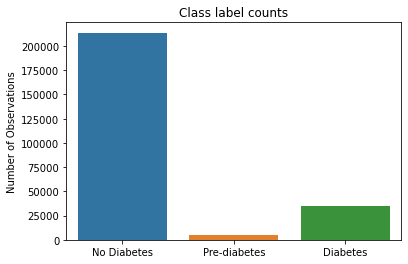

In [ ]:
sns.countplot(x = data_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts')

print('Number of observations with no diabetes:', data_y[data_y==0].count())
print('Number of observations with pre-diabetes:', data_y[data_y==1].count())
print('Number of observations with diabetes:', data_y[data_y==2].count())

There is a class imbalance in the CDC diabetes dataset. The number of pre-diabetes and diabetes cases is relatively very small compared to the no diabetes cohort.

### Train-Test Split, Use test dataset as hold-out set

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y, test_size = 0.1, random_state = 32)

### The most basic model - classify all cases as no-diabetes

If we classify all the observations as no diabetes: 

                                           Predicted
                                  No Diabetes	Pre-diabetes	Diabetes
    
                   No Diabetes      21409	        0       	 0
                   
     Actual        Pre-diabetes     420 	        0	         0

                   Diabetes         3539	        0	         0

In [ ]:
print('F1-score when we classify all observations as no-diabetes:', metrics.accuracy_score(test_y, np.zeros(len(logistic_clf_predict))))
print('F1-score when we classify all observations as no-diabetes:', metrics.f1_score(test_y, np.zeros(len(logistic_clf_predict)), labels = [0,1,2], average = None))

F1-score when we classify all observations as no-diabetes: 0.8439372437716809
F1-score when we classify all observations as no-diabetes: [0.91536439 0.         0.        ]


As our goal is to design a model that accurately identifies people at risk of diabetes or who have diabetes, we can readily see from above cells that this naive assumption of classifying everything as no diabetes and then using accuracy to evaluate model is faulty. As it is heavily skewed due to class imbalance. Hence accuracy is not a good metric for evaluating model performance. Instead, we compare the confusion matrices and F1-scores to evaluate model performance.

### 2 methods of correction of Class Imbalance in the training dataset
##### Downsampling:
 Diabetes and No-Diabetes observations will be downsampled - So randomly select ~4000 onservations from each class
##### Upsampling:
 Diabetes and Prediabetes observations will be upsampled - So duplicate the onservations from each class


In [ ]:
# Load Downsampled dataset

train_dwn = pd.read_csv('train_data_downsampled.csv')
train_dwn_x = train_dwn.iloc[:,1:] # features
train_dwn_y = train_dwn.iloc[:,0] # labels

# Load Upsampled dataset
train_up = pd.read_csv('train_data_upsampled.csv')
train_up_x = train_up.iloc[:,1:] # features
train_up_y = train_up.iloc[:,0] # labels

# Load test data
test_data = pd.read_csv('test_BMI_processed.csv')
test_x = test_data.iloc[:, 1:]
test_y = test_data.iloc[:, 0]

FileNotFoundError: ignored

In [ ]:
sns.countplot(x = train_dwn_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts -  Downsampled Dataset')

print('Number of observations with no diabetes:', train_dwn_y.value_counts()[0])
print('Number of observations with pre-diabetes:', train_dwn_y.value_counts()[1])
print('Number of observations with diabetes:', train_dwn_y.value_counts()[2])

NameError: ignored

In [ ]:
sns.countplot(x = train_up_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts - Upsampled Dataset')

print('Number of observations with no diabetes:', train_up_y.value_counts()[0])
print('Number of observations with pre-diabetes:', train_up_y.value_counts()[1])
print('Number of observations with diabetes:', train_up_y.value_counts()[2])

### Evaluate performance of baseline Model - Logistic Regression - using downsampled and upsampled training dataset

#### Logistic Regression - multi-class - downsampled dataset

In [ ]:
logistic_clf_model_dwn = LogisticRegression(multi_class = 'ovr', max_iter=10000)
logistic_clf_model_dwn.fit(train_dwn_x,train_dwn_y) # train logistic regression on training data using one vs rest
logistic_clf_dwn_predict = logistic_clf_model_dwn.predict(test_x)

NameError: ignored

##### model performance on test set

In [ ]:
# downsampled
cm_logistic_clf_dwn = metrics.confusion_matrix(test_y, logistic_clf_dwn_predict, labels = [0,1,2])
cm_logistic_clf_dwn =  pd.DataFrame(cm_logistic_clf_dwn, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Downsampled \n \n  \033[0m', '\t  \t Predicted')
cm_logistic_clf_dwn

NameError: ignored

#### Logistic Regression - multi-class - Upsampled dataset

In [ ]:
logistic_clf_model_up = LogisticRegression(multi_class = 'ovr', max_iter=10000)
logistic_clf_model_up.fit(train_up_x,train_up_y) # train logistic regression on training data using one vs rest
logistic_clf_up_predict = logistic_clf_model_up.predict(test_x)

##### model performance on test set

In [ ]:
# Upsampled
cm_logistic_clf_up = metrics.confusion_matrix(test_y, logistic_clf_up_predict, labels = [0,1,2])
cm_logistic_clf_up =  pd.DataFrame(cm_logistic_clf_up, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Upsampled \n \n  \033[0m', '\t  \t Predicted')
cm_logistic_clf_up

#### Comparing  performance of Logistic Regression models trained on UpSampled and DownSampled Data

In [ ]:
print('Model trained on Downsampled Data \n')
print('Precision for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))
print('Recall for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))
print('F1-score for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))

print('\n \nModel trained on Upsampled Data\n')
print('Precision for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))
print('Recall for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))
print('F1-score for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))

On comparing the two models we can see that the model trained on Upsampled data performs better than the model trained on downsampled data by a very small fraction < 1 %. Hence, we chose to train the remaining models supervised - KNN, Ada Boost, SVM - on the downsampled data to save computation time.

### K Nearest Neighbors

In [ ]:
# split downsampled data into train and validation
train_x_small, val_x, train_y_small, val_y = train_test_split(train_dwn_x, train_dwn_y, test_size = 0.1, random_state = 32)

In [ ]:
acc_val_knn = []
train_acc = []
for k in np.arange(1, 60, 5):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y))# compute accuracy of predictiosn on validation set
    train_acc.append(KNN_model.score(train_x_small, train_y_small))# compute accuracy of predictiosn on train set

Text(0, 0.5, 'Accuracy')

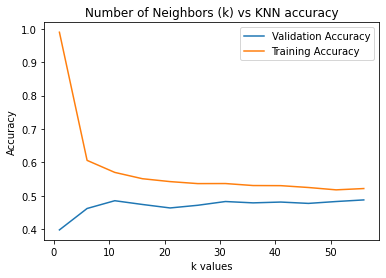

In [ ]:
plt.plot(np.arange(1, 60, 5), acc_val_knn)
plt.plot(np.arange(1, 60, 5), train_acc)
plt.title('Number of Neighbors (k) vs KNN accuracy')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('k values')
plt.ylabel('Accuracy')

We can see that the optimal K value is somewhere between 1 and 12

In [ ]:
acc_val_knn = []
train_acc = []
for k in np.arange(1, 14, 2):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y)) # compute accuracy of predictiosn on validation set
    train_acc.append(KNN_model.score(train_x_small, train_y_small))# compute accuracy of predictiosn on train set

Text(0, 0.5, ' Validation Accuracy')

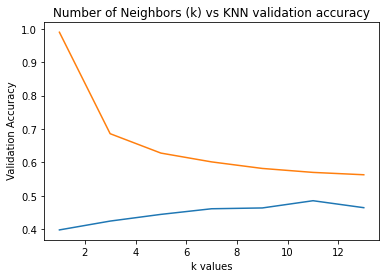

In [ ]:
plt.plot(np.arange(1, 14, 2), acc_val_knn)
plt.plot(np.arange(1, 14, 2), train_acc)

plt.title('Number of Neighbors (k) vs KNN validation accuracy')
plt.xlabel('k values')
plt.ylabel(' Validation Accuracy')

We choose K=11, based on the accuracy plot, since the validation accuracy is 

In [ ]:
# Model KNN with K = 11
k = 11
KNN_model = KNN(n_neighbors = k)
KNN_model.fit(train_dwn_x, train_dwn_y)
KNN_predict = KNN_model.predict(test_x)

#### KNN Model Performance

In [ ]:
cm_KNN = metrics.confusion_matrix(test_y, KNN_predict, labels = [0,1,2])
cm_KNN =  pd.DataFrame(cm_KNN, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Actual')
cm_KNN

	   Confusion Matrix 
 
   	  	 Actual


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,13055,4899,3455
Pre-diabetes,104,189,180
Diabetes,732,1276,1478


In [ ]:
print('Precision for KNN classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, KNN_predict, labels = [0,1,2], average = None))
print('Recall for KNN classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, KNN_predict, labels = [0,1,2], average = None))
print('F1-score for KNN classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, KNN_predict, labels = [0,1,2], average = None))


Precision for KNN classifier for predicting 0, 1, 2 labels: [0.93981715 0.0296983  0.28906708]
Recall for KNN classifier for predicting 0, 1, 2 labels: [0.60979028 0.39957717 0.42398164]
F1-score for KNN classifier for predicting 0, 1, 2 labels: [0.73966006 0.05528741 0.3437609 ]


### Ada-Boost

In [ ]:
acc_val_ada = []
acc_train_ada =[]
for estimators in range(50,2000, 100):
    ada_model = AdaBoost(n_estimators = estimators, random_state = 32)
    ada_model.fit(train_x_small, train_y_small)
    acc_val_ada.append(ada_model.score(val_x, val_y))
    acc_train_ada.append(ada_model.score(train_x_small, train_y_small))
    

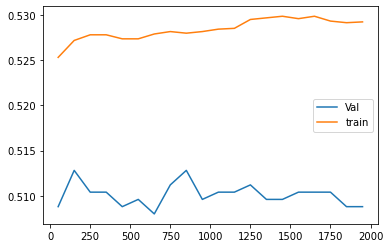

In [ ]:
plt.plot(range(50,2000, 100), acc_val_ada)
plt.plot(range(50,2000, 100), acc_train_ada)
plt.legend(['Val','train'])

We chose number of estimators = 150 based on the above plot, since it gives best validation accuracy.

In [ ]:
estimators = 150
ada_model = AdaBoost(n_estimators = estimators, random_state = 32)
ada_model.fit(train_x, train_y)
ada_predict = ada_model.predict(test_x)

In [ ]:
cm_ada = metrics.confusion_matrix(test_y, ada_predict, labels = [0,1,2])
cm_ada =  pd.DataFrame(cm_ada, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_ada


	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,13850,3763,3796
Pre-diabetes,114,150,209
Diabetes,585,823,2078


In [ ]:
print('Precision for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, ada_predict, labels = [0,1,2], average = None))
print('Recall for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, ada_predict, labels = [0,1,2], average = None))
print('F1-score for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, ada_predict, labels = [0,1,2], average = None))


Precision for Ada Boost classifier for predicting 0, 1, 2 labels: [0.95195546 0.0316723  0.34160776]
Recall for Ada Boost classifier for predicting 0, 1, 2 labels: [0.64692419 0.31712474 0.59609868]
F1-score for Ada Boost classifier for predicting 0, 1, 2 labels: [0.77034318 0.05759263 0.43431916]


In [ ]:
enc = preprocessing.OneHotEncoder().fit(np.array(train_y).reshape([-1,1]))
train_y_ohe = enc.transform(np.array(train_y).reshape([-1,1])).toarray()
test_y_ohe = enc.transform(np.array(test_y).reshape([-1,1])).toarray()

In [ ]:
ada_model_0 = AdaBoost(n_estimators = 150, random_state = 32)
ada_model_1 = AdaBoost(n_estimators = 150, random_state = 32)
ada_model_2 = AdaBoost(n_estimators = 150, random_state = 32)

ada_model_0.fit(train_x, train_y_ohe[:,0])
ada_model_1.fit(train_x, train_y_ohe[:,1])
ada_model_2.fit(train_x, train_y_ohe[:,2])

pred_0 = ada_model_0.predict_proba(test_x) # prediction using model_0
pred_1 = ada_model_1.predict_proba(test_x) # prediction using model_1
pred_2 = ada_model_2.predict_proba(test_x) # prediction using model_2

AdaBoostClassifier(n_estimators=150, random_state=32)

In [ ]:
#concatenate probability prediction of each label by each model
pred_prob = np.concatenate([np.array(pred_0[:,1]).reshape([-1,1]), np.array(pred_1[:,1]).reshape([-1,1]), np.array(pred_2[:,1]).reshape([-1,1])], axis=1)
normalized_ada_multi_predict = np.divide(pred_prob,np.sum(pred_prob, axis = 1).reshape([-1,1]))
predict_multi_ada = np.argmax(normalized_ada_multi_predict, axis = 1)

In [ ]:
cm_ada_p = metrics.confusion_matrix(test_y, predict_multi_ada, labels = [0,1,2])
cm_ada_p =  pd.DataFrame(cm_ada_p, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_ada_p

	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,14287,3331,3791
Pre-diabetes,121,139,213
Diabetes,642,771,2073


In [ ]:
print('Precision for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))
print('Recall for Multiple Binary Ada Boosbt classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))
print('F1-score for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))


Precision for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels: [0.94930233 0.03277529 0.34112226]
Recall for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels: [0.66733617 0.29386892 0.59466437]
F1-score for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels: [0.78372967 0.05897327 0.43354596]


# SVM

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train_data_downsampled.csv')
test = pd.read_csv('/content/drive/MyDrive/test_BMI_processed.csv')
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

ohe_data = pd.get_dummies(y_train, columns = ['Diabetes_012'])
ohe_test = pd.get_dummies(y_test, columns = ['Diabetes_012'])

print(ohe_data.loc[:,1])
print(X_train.shape)

3043     0
1188     0
10340    1
9895     0
5322     0
        ..
11964    1
5191     0
5390     0
860      0
7270     0
Name: 1, Length: 11226, dtype: uint8
(11226, 21)


In [ ]:
pipe = Pipeline([('kernelize', Nystroem(random_state=32)), ('svc', svm.LinearSVC(dual = False, class_weight='balanced'))])
param_grid = dict(kernelize__n_components=[300, 400, 500, 600],
                  kernelize__gamma=[0.00005, 0.0001, 0.0005, 0.001],
                  svc__C=[50, 100, 150, 200])
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1)
%time grid_search.fit(X_val, y_val)

CPU times: user 2.06 s, sys: 265 ms, total: 2.33 s
Wall time: 1min 7s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kernelize', Nystroem(random_state=32)),
                                       ('svc',
                                        LinearSVC(class_weight='balanced',
                                                  dual=False))]),
             n_jobs=-1,
             param_grid={'kernelize__gamma': [5e-05, 0.0001, 0.0005, 0.001],
                         'kernelize__n_components': [300, 400, 500, 600],
                         'svc__C': [50, 100, 150, 200]},
             scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
pd.DataFrame(grid_search.cv_results_)

{'kernelize__gamma': 0.0005, 'kernelize__n_components': 400, 'svc__C': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernelize__gamma,param_kernelize__n_components,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214480,0.009644,0.012807,0.001083,5e-05,300,50,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.491472,0.467636,0.489056,0.482721,0.010712,45
1,0.236237,0.013572,0.013990,0.002136,5e-05,300,100,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.498577,0.455469,0.488466,0.480837,0.018407,49
2,0.244001,0.007288,0.013144,0.000519,5e-05,300,150,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.499540,0.450879,0.486920,0.479113,0.020619,56
3,0.274599,0.012876,0.013065,0.000189,5e-05,300,200,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.504318,0.459316,0.492273,0.485302,0.019022,36
4,0.313843,0.004781,0.018472,0.002294,5e-05,400,50,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.491472,0.467636,0.489056,0.482721,0.010712,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.227567,0.013408,0.021207,0.001265,0.001,500,200,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.476569,0.482243,0.474031,0.477614,0.003433,62
60,1.072656,0.012037,0.030712,0.003142,0.001,600,50,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.490104,0.486532,0.492918,0.489851,0.002613,15
61,1.347637,0.024969,0.027305,0.001964,0.001,600,100,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.488511,0.492153,0.494908,0.491857,0.002620,5
62,1.572036,0.101450,0.029572,0.001799,0.001,600,150,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.476821,0.480225,0.478998,0.478681,0.001408,58


In [ ]:
clf = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time clf.fit(data_transformed, y_train)

CPU times: user 15.7 s, sys: 91.8 ms, total: 15.8 s
Wall time: 15.6 s


LinearSVC(C=100, class_weight='balanced', dual=False)

In [ ]:
y_pred = clf.predict(test_transformed)
print('train accuracy: ', clf.score(data_transformed, y_train))
print('test accuracy: ', clf.score(test_transformed, y_test))
print('weighted f1: ', metrics.f1_score(y_test, y_pred, average='weighted'))
print(metrics.f1_score(y_test, y_pred, labels=[0,1,2], average=None))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.multilabel_confusion_matrix(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred, labels = [0,1,2], average = None))
print('recall: ', metrics.recall_score(y_test, y_pred, labels = [0,1,2], average = None))

train accuracy:  0.5439159094958133
test accuracy:  0.6348943550930306
weighted f1:  0.711513341163448
[0.77127926 0.05658537 0.43332987]
[[13873  3690  3846]
 [  111   145   217]
 [  581   817  2088]]
[[[ 3267   692]
  [ 7536 13873]]

 [[20388  4507]
  [  328   145]]

 [[17819  4063]
  [ 1398  2088]]]
precision:  [0.95248884 0.03116939 0.339457  ]
recall:  [0.64799851 0.30655391 0.5989673 ]


**One-hot encoding**

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit_transform

In [ ]:

model_0 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_0.fit(data_transformed, ohe_data.loc[:,0])

model_1 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_1.fit(data_transformed, ohe_data.loc[:,1])

model_2 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_2.fit(data_transformed, ohe_data.loc[:,2])

CPU times: user 5.12 s, sys: 97.9 ms, total: 5.22 s
Wall time: 5.09 s
CPU times: user 7.5 s, sys: 104 ms, total: 7.6 s
Wall time: 7.46 s
CPU times: user 6.91 s, sys: 95.9 ms, total: 7.01 s
Wall time: 6.87 s


LinearSVC(C=100, class_weight='balanced', dual=False)

In [ ]:
pred_0 = model_0.decision_function(test_transformed)
pred_1 = model_1.decision_function(test_transformed)
pred_2 = model_2.decision_function(test_transformed)

pred = np.concatenate((pred_0.reshape(-1, 1), pred_1.reshape(-1, 1), pred_2.reshape(-1, 1)), axis=1)
#y_pred = np.argmax(pred_prob, axis = 1)
y_pred = lb.inverse_transform(pred, threshold=0)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
print('weighted f1: ', metrics.f1_score(y_test, y_pred, average='weighted'))
print(metrics.f1_score(y_test, y_pred, labels=[0,1,2], average=None))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.multilabel_confusion_matrix(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred, labels = [0,1,2], average = None))
print('recall: ', metrics.recall_score(y_test, y_pred, labels = [0,1,2], average = None))

weighted f1:  0.7043248670792507
[0.76277219 0.05802777 0.43306836]
[[13609  4099  3701]
 [  105   163   205]
 [  560   883  2043]]
[[[ 3294   665]
  [ 7800 13609]]

 [[19913  4982]
  [  310   163]]

 [[17976  3906]
  [ 1443  2043]]]
precision:  [0.9534118  0.03168124 0.34341906]
recall:  [0.63566724 0.34460888 0.58605852]
